In [1]:
import warnings

warnings.simplefilter('ignore', FutureWarning)

import pandas as pd
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.figsize'] = (12, 8)

,index,USD
0,2002/4/1,133.15
1,2002/4/2,133.20
2,2002/4/3,133.20
3,2002/4/4,133.10
4,2002/4/5,132.30
...,...,...
4902,2022/4/4,122.44
4903,2022/4/5,122.58
4904,2022/4/6,123.90
4905,2022/4/7,123.66


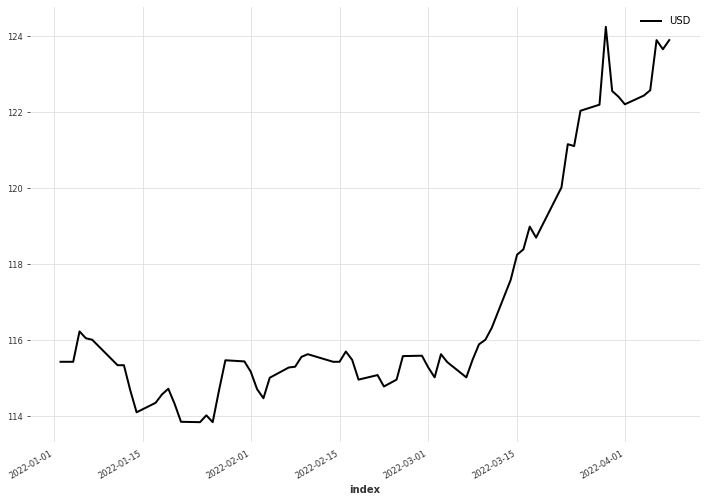

In [3]:
df = pd.read_csv('data/quote.csv', encoding='SJIS', skiprows=2, index_col=0)
df = df.reset_index()[['index', 'USD']]

display(df)

series = TimeSeries.from_dataframe(df, time_col='index', freq='D').drop_before(pd.Timestamp('2022/01/01'))
series = fill_missing_values(series)
series.plot()

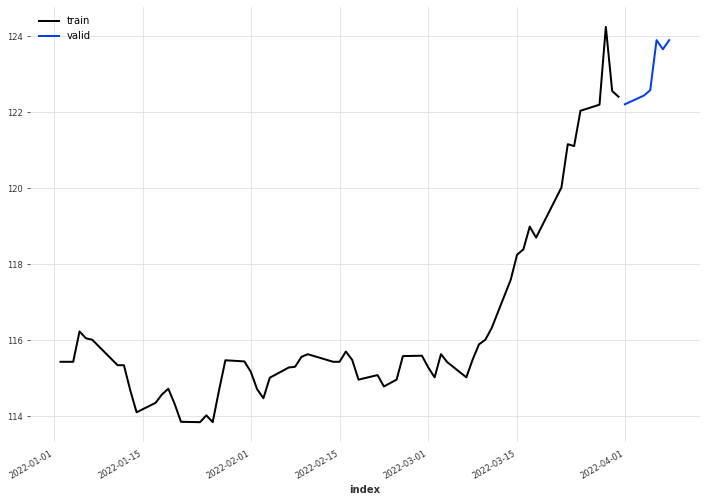

In [4]:
train, valid = series.split_before(pd.Timestamp('2022/04/01'))
train.plot(label='train')
valid.plot(label='valid')

In [5]:
from darts.models import ExponentialSmoothing, Prophet, AutoARIMA, Theta, NaiveDrift, ARIMA, KalmanForecaster

models = [
    NaiveDrift(),
    ExponentialSmoothing(),
    ARIMA(),
    AutoARIMA(),
    Prophet(),
    Theta(),
    KalmanForecaster()
]

Importing plotly failed. Interactive plots will not work.


/Users/hideki/miniforge3/envs/darts/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


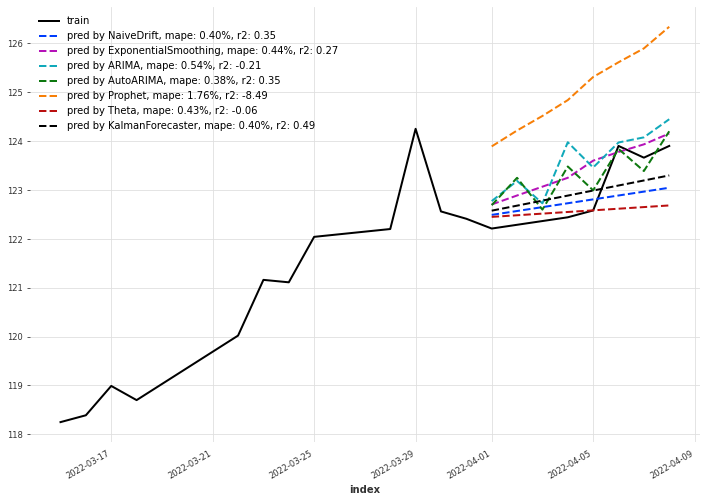

In [6]:
from darts.metrics import mape, r2_score

series.drop_before(pd.Timestamp('2022/03/14')).plot(label='train')

for model in models:
    model.fit(train)
    preds = model.predict(len(valid))
    _mape = mape(valid, preds)
    _r2 = r2_score(valid, preds)

    preds.plot(label=f'pred by {model.__class__.__name__}, mape: {_mape:.2f}%, r2: {_r2:.2f}', linestyle='dashed')

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/Users/hideki/miniforge3/envs/darts/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to overr

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

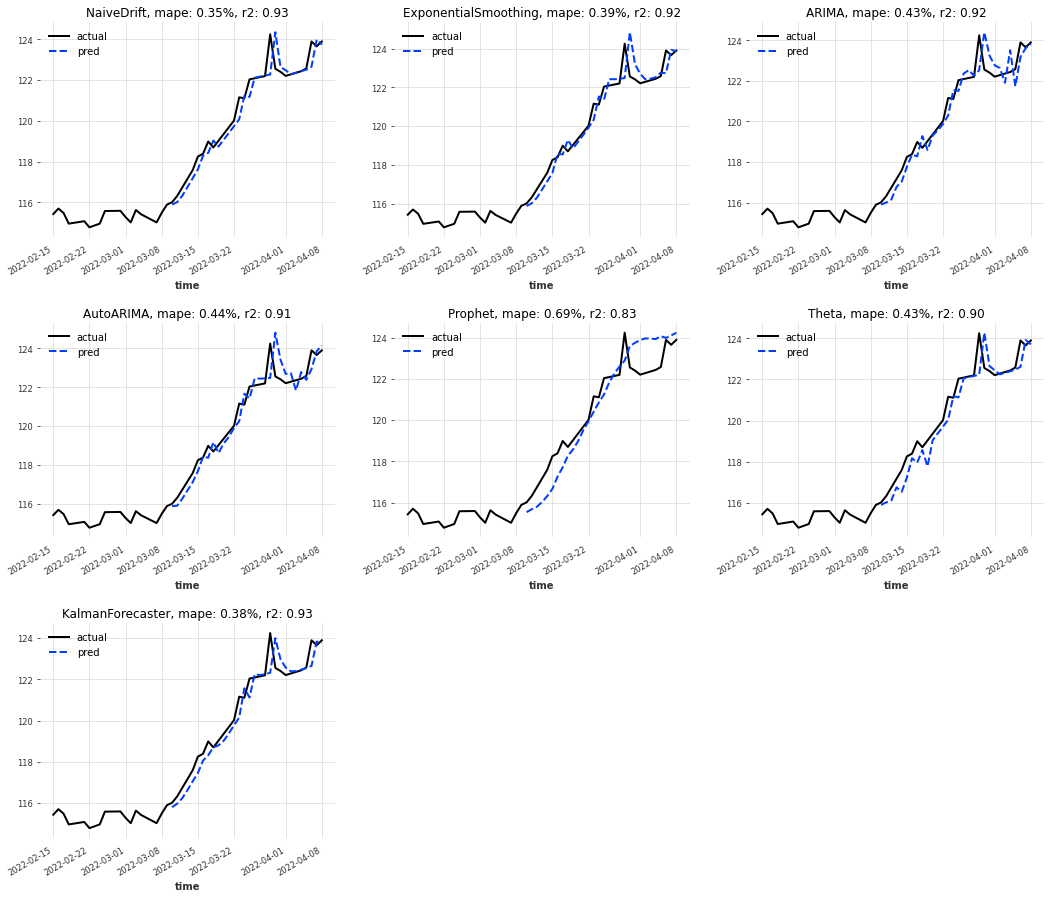

In [7]:
import math

fig_cols_count = 3
fig_rows_count = math.ceil(len(models) / fig_cols_count)
fig = plt.figure(figsize=(18, 5 * fig_rows_count))
fig.subplots_adjust(hspace=0.4)

for i, model in enumerate(models):
    ax = fig.add_subplot(fig_rows_count, fig_cols_count, i + 1)
    series.drop_before(pd.Timestamp('2022/02/14')).plot(label='actual')
    historical_forecast = model.historical_forecasts(
        series, start=0.7, forecast_horizon=1, verbose=True
    )
    _mape = mape(series, historical_forecast)
    _r2 = r2_score(series, historical_forecast)
    historical_forecast.plot(label=f'pred', linestyle='dashed')
    ax.set_title(f'{model.__class__.__name__}, mape: {_mape:.2f}%, r2: {_r2:.2f}')